In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import skimage
import pylab as plt
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepleeo.dataset.data_augment as dtaug
import deepleeo.dataset.utils as dsutils 
import deepleeo.utils.geofunctions as gf
from deepleeo.networks import fcn

reload(dtaug)
reload(dsutils)
reload(fcn)
reload(gf)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepleeo.utils.geofunctions' from '../src/deepleeo/utils/geofunctions.py'>

# Load input Dataset

In [2]:
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real', 'generated')
DATASET_FILE = os.path.join(DATA_DIR, 'samples_dataset_bin.npz')
#model_dir = os.path.join(DATA_DIR, 'tf_logs', "test_FCN_%s" % datetime.now().strftime('%d_%m_%Y-%H_%M_%S'))
model_dir = "/home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug"

In [3]:
raster_path = os.path.join(DATA_DIR, "..", "Landsat8_225064_17072016_R6G5B4_clip.tif")

In [4]:
dataset = np.load(DATASET_FILE)

print("Data Loaded:")
print("  -> Images: ", len(dataset["images"]))
print("  -> Labels: ", len(dataset["labels"]))
print("  -> Classes: ", len(dataset["classes"]))

print("Images shape: ", dataset["images"][0].shape)
print("Labels shape: ", dataset["labels"][0].shape)
print("UNIQUE LABELS: ", np.unique(dataset["labels"]))

Data Loaded:
  -> Images:  5000
  -> Labels:  5000
  -> Classes:  2
Images shape:  (128, 128, 3)
Labels shape:  (128, 128, 1)
UNIQUE LABELS:  [0 1]


In [5]:
#plt.figure(figsize=(4,4))
#img_plt = skimage.img_as_float(dataset["images"][0])
#img_plt = dataset["images"][0]
#plt.imshow(img_plt)
#plt.axis('off')

# Perform Data Augmentation

In [6]:
reload(dtaug)
angles = [90, 180, 270]
rotated_imgs = dtaug.rotate_images(dataset["images"], angles)
flipped_imgs = dtaug.flip_images(dataset["images"])

new_dataset = {}
new_dataset["images"] = np.concatenate((dataset["images"], rotated_imgs))
new_dataset["images"] = np.concatenate((new_dataset["images"], flipped_imgs))

rotated_lbls = dtaug.rotate_images(dataset["labels"], angles)
flipped_lbls = dtaug.flip_images(dataset["labels"])

new_dataset["labels"] = np.concatenate((dataset["labels"], rotated_lbls))
new_dataset["labels"] = np.concatenate((new_dataset["labels"], flipped_lbls)).astype(dtype=np.int32)

new_dataset["classes"] = dataset["classes"]

print("Data Augmentation Applied:")
print("  -> Images: ", new_dataset["images"].shape)
print("  -> Labels: ", new_dataset["labels"].shape)

#print("  -> Unique Images: ", np.unique(new_dataset["images"]))
print("  -> Unique Labels: ", np.unique(new_dataset["labels"]))

Data Augmentation Applied:
  -> Images:  (35000, 128, 128, 3)
  -> Labels:  (35000, 128, 128, 1)
  -> Unique Labels:  [0 1]


# Split dataset between train, test and validation data

In [7]:
train_images, test_images, valid_images, train_labels, test_labels, valid_labels = dsutils.split_dataset(new_dataset)

print("Splitted dataset:")
print("  -> Train images: ", train_images.shape)
print("  -> Test images: ", test_images.shape)
print("  -> Validation images: ", valid_images.shape)
print("  -> Train Labels: ", train_labels.shape)
print("  -> Test Labels: ", test_labels.shape)
print("  -> Validation Labels: ", valid_labels.shape)

print("  -> UNIQUE TRAIN LABELS: ", np.unique(train_labels))
print("  -> UNIQUE TEST LABELS: ", np.unique(test_labels))
print("  -> UNIQUE VALIDATION LABELS: ", np.unique(valid_labels))

Splitted dataset:
  -> Train images:  (24500, 128, 128, 3)
  -> Test images:  (10500, 128, 128, 3)
  -> Validation images:  (0, 128, 128, 3)
  -> Train Labels:  (24500, 128, 128, 1)
  -> Test Labels:  (10500, 128, 128, 1)
  -> Validation Labels:  (0, 128, 128, 1)
  -> UNIQUE TRAIN LABELS:  [0 1]
  -> UNIQUE TEST LABELS:  [0 1]
  -> UNIQUE VALIDATION LABELS:  []


# Train the Network

In [8]:
params = {
    "epochs": 20,
    "batch_size": 400,
    "learning_rate": 0.01,
    "class_names": new_dataset["classes"],
    "multi_gpu": False
}

In [9]:
reload(fcn)

fcn.fcn_train(train_images, test_images, train_labels, test_labels, params, model_dir)

Instructions for updating:
Please use `tf.contrib.distribute.MirroredStrategy` instead.
INFO:tensorflow:Replicating the `model_fn` across ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3'].  Variables are going to be placed on ['/CPU:0'].  Consolidation device is going to be /CPU:0.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_master': '', '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efb79531ba8>, '_train_distribute': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_device_fn': None, '_service': None, '_evaluation_master': '', '_session_config': None, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_is_chief': True, '_task_id': 0, '_model_dir': '/home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug', '_global_id_in_clust

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 248 into /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt.
INFO:tensorflow:
INFO:tensorflow:loss = 0.33797958, step = 248
INFO:tensorflow: (17.782 sec)
INFO:tensorflow: (15.178 sec)
INFO:tensorflow:Saving checkpoints for 310 into /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt.
INFO:tensorflow:Loss for final step: 0.35673034.
---------------
Evaluating...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-11-19:30:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt-310
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-11-19:31:10
INFO:tensorflow:S

INFO:tensorflow:
INFO:tensorflow:loss = 0.3705098, step = 558
INFO:tensorflow: (17.834 sec)
INFO:tensorflow: (15.228 sec)
INFO:tensorflow:Saving checkpoints for 620 into /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt.
INFO:tensorflow:Loss for final step: 0.39598757.
---------------
Evaluating...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-11-19:37:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt-620
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-11-19:37:50
INFO:tensorflow:Saving dict for global step 620: accuracy = 0.67132336, global_step = 620, loss = 0.3291071
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 620: /home/raian/doutorado/DeepLeEO/data_real/generated/tf

INFO:tensorflow:Loss for final step: 0.39143312.
---------------
Evaluating...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-11-19:44:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt-930
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-11-19:44:29
INFO:tensorflow:Saving dict for global step 930: accuracy = 0.67132336, global_step = 930, loss = 0.3291071
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 930: /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt-930
Epoch  16
---------------
Training...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring pa

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-11-19:50:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt-1240
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-11-19:51:09
INFO:tensorflow:Saving dict for global step 1240: accuracy = 0.67132336, global_step = 1240, loss = 0.3291071
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1240: /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt-1240


In [ ]:
#fcn.fcn_evaluate(valid_images, valid_labels,)

In [10]:
#TODO: Verificar aqui. Seria necessário inverter x e y?
def generate_sequential_chips(img_array, chip_size=128):
    x_size, y_size, nbands = img_array.shape
    
    struct = {"chips":[], "coords":[]}
    for x_start in range(0, x_size, chip_size):
        x_end = x_start + chip_size
        
        if x_end > x_start:
            x_end = x_size
            x_start = x_end - chip_size
        
        for y_start in range(0, y_size, chip_size):
            y_end = y_start + chip_size
            
            if y_end > y_size:
                y_end = y_size
                y_start = y_end - chip_size
                
            chip_array = img_array[x_start:x_end, y_start:y_end, :]
            
            struct["chips"].append(chip_array)
            struct["coords"].append({"x_start": x_start, "y_start": y_start})
        
    return struct

In [11]:
import deepleeo.dataset.preprocessor as prep

reload(gf)
reload(prep)
#raster_array = gf.load_image(raster_path, 0)
#print(raster_path)

preproc = prep.Preprocessor(raster_path, no_data=-9999)
raster_array = preproc.standardize_image()
chips = generate_sequential_chips(raster_array)

print(len(chips["chips"]))

2597


In [20]:
reload(fcn)

#trained_model = "/home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_22_08_2018-20_24_36"

predictions = fcn.fcn_predict(chips["chips"], params=params, model_dir=model_dir)
out_pred = chips.copy()
out_pred["chips"] = predictions.copy()

Classifying image with structure  (2597, 128, 128, 3) ...
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/DeepLeEO/data_real/generated/tf_logs/test_debug/model.ckpt-1240
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [21]:
def discretize_values(data, numberClass, startValue = 0):
    for clazz in range(startValue, (numberClass + 1) ):
        if clazz == startValue:
            classFilter = (data <= clazz + 0.5)
        elif  clazz == numberClass:
            classFilter = (data > clazz - 0.5)
        else:
            classFilter = np.logical_and(data > clazz - 0.5, data <= clazz + 0.5) 
        data[classFilter] = clazz

    return data.astype(np.uint8)

new_pred = []
for chip in out_pred["chips"]:
    new_pred.append(discretize_values(chip, 2, 0))
    
out_pred["chips"] = new_pred.copy()

In [22]:
import gdal
import osr

output_path = os.path.join(DATA_DIR, "prediction.tiff")

def write_prediction(output_path, base_raster, pred_struct, output_format="GTiff", dataType=gdal.GDT_UInt16):
    driver = gdal.GetDriverByName(output_format)
    base_ds = gdal.Open(base_raster)
    
    x_start, pixel_width, _, y_start, _, pixel_height = base_ds.GetGeoTransform()
    x_size = base_ds.RasterXSize
    y_size = base_ds.RasterYSize
    
    srs = osr.SpatialReference()
    srs.ImportFromWkt(base_ds.GetProjectionRef())
    
    out_ds = driver.Create(output_path, x_size, y_size, 1, dataType)
    out_ds.SetGeoTransform((x_start, pixel_width, 0, y_start, 0, pixel_height))
    out_ds.SetProjection(srs.ExportToWkt())
    out_band = out_ds.GetRasterBand(1)
    
    for idx in range(1, len(pred_struct["chips"])):
        chip = pred_struct["chips"][idx]
        chip = np.squeeze(chip)
        out_band.WriteArray(chip, pred_struct["coords"][idx]["y_start"], pred_struct["coords"][idx]["x_start"])
        
    out_band.FlushCache()
    
write_prediction(output_path, raster_path, out_pred)

[0 1]
MIN:  0
MAX:  1


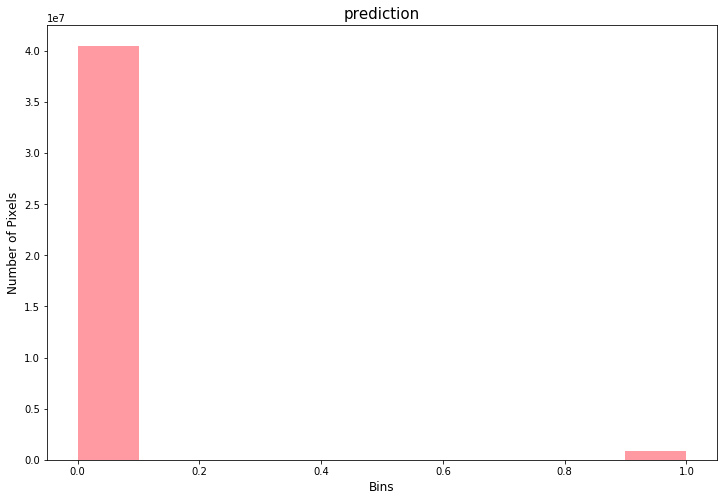

In [23]:
new_ds = gdal.Open(output_path)
rarr = new_ds.ReadAsArray()

print(np.unique(rarr))

from deepleeo.utils import image
reload(image)

print("MIN: ", np.min(rarr))
print("MAX: ", np.max(rarr))

image.plot_image_histogram(rarr, title = "prediction")

Raster Shape: (6166, 6711)


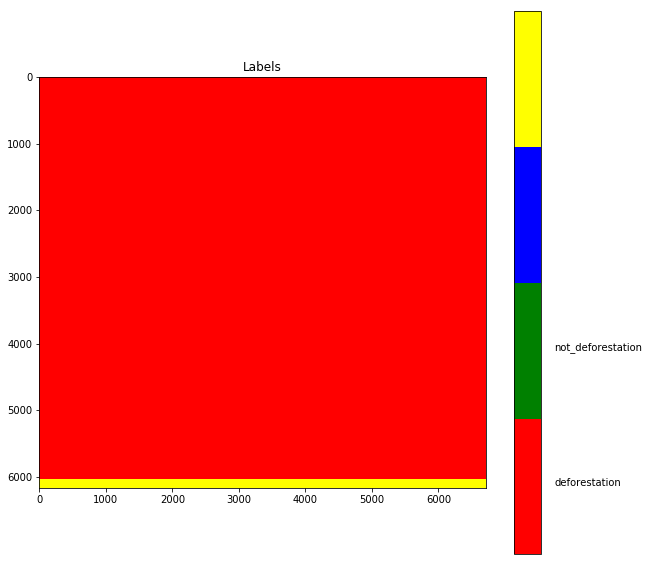

In [24]:
import pylab as pl
from matplotlib.colors import ListedColormap

pl.figure(figsize=(10, 10))
pl.title('Labels')
print("Raster Shape:", rarr.shape)

colorMap = ListedColormap(["red", "green", "blue", "yellow"])
pl.imshow(rarr, cmap=colorMap)
cbar = pl.colorbar()
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(new_dataset["classes"]):
    cbar.ax.text(1.5, (2 * j + 1) / 8, lab, ha='left')

cbar.ax.get_yaxis().labelpad = 15
#cbar.ax.set_yticklabels(class_names)